## Binary Classification to Multiclass classification

## Data Cleaning

In [1]:
import pandas as pd
from helpers import load_config
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

config_path = os.path.join("configs", "configs.yaml")
config = load_config(config_path)

In [2]:
df = pd.read_csv(config["STORAGE_DIR_STUDY1"] + "pathological_df.csv")
df_recur = df[df["PFS_STATUS"] == "1:PROGRESSION"]
df_non_recur = df[df["PFS_STATUS"] == "0:CENSORED"]
print(f"Recurrence df: {df_recur.shape}, Non-recurrence df: {df_non_recur.shape}")

Recurrence df: (20, 23), Non-recurrence df: (16, 23)


In [3]:
df_recur["PFS_MONTHS"].sort_values().reset_index(drop=True)

0      0.558898
1      1.315054
2      1.610941
3      1.939705
4      2.367097
5      3.123253
6      5.588980
7      6.509518
8      7.068416
9      7.101292
10     7.134168
11     7.791695
12     7.956077
13     8.679357
14     9.238255
15     9.698524
16    11.901239
17    12.394385
18    13.939573
19    18.049117
Name: PFS_MONTHS, dtype: float64

In [4]:
conditions = [
    (df_recur['PFS_MONTHS'] < 3),
    (df_recur['PFS_MONTHS'] >= 3) & (df_recur['PFS_MONTHS'] < 7.5),
    (df_recur['PFS_MONTHS'] >= 7.5) & (df_recur['PFS_MONTHS'] < 10),
    (df_recur['PFS_MONTHS'] >= 10)
]

choices = ["0-3", "3-7.5", "7.5-10", "10-19"]

df_recur["BINNED"] = np.select(conditions, choices, default='Unknown')

df_recur[["BINNED", "PFS_MONTHS"]].sort_values(by="PFS_MONTHS")

/var/folders/_0/qrjsyj4n0r951n63lt8qdzrc0000gn/T/ipykernel_83642/42834312.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recur["BINNED"] = np.select(conditions, choices, default='Unknown')


,BINNED,PFS_MONTHS
27,0-3,0.558898
21,0-3,1.315054
29,0-3,1.610941
28,0-3,1.939705
35,0-3,2.367097
14,3-7.5,3.123253
24,3-7.5,5.588980
30,3-7.5,6.509518
10,3-7.5,7.068416
0,3-7.5,7.101292


In [5]:
df_non_recur["PFS_MONTHS"].sort_values().reset_index(drop=True)

0      0.328764
1      0.690403
2      1.643818
3      8.909491
4     13.216294
5     13.808068
6     17.062827
7     19.791564
8     21.369629
9     23.309334
10    35.407831
11    37.906434
12    47.637834
13    50.695335
14    53.062432
15    64.963672
Name: PFS_MONTHS, dtype: float64

Goal: Multiclass classification of when cancer will occur. 
- Sooner = Higher risk patient
- Later = Lower risk patient

Strategy: 
- Look at just patients for whom cancer did recur and figure out ideal bin sizes.
    - Bins: ["0-3", "3-7.5", "7.5-10", "10-19"]
- For the patients for whom cancer did NOT recur,
    - if time of capturing data is less than 19 months, they could have got cancer after this data was collected, hence they cannot be added in any bin. So removing such patients (8 patients).
    - if time when data was captured is more than 19 months from initial diagnosis, it adds value to add these patients with a new bin of 19+, which here indicates cancer did not recur within 19 months, which indicates a low risk patient(8 patients).

In [6]:
df_non_recur = df_non_recur[df_non_recur["PFS_MONTHS"] > 19]
df_non_recur["BINNED"] = "19+"
df_non_recur[["BINNED", "PFS_MONTHS"]] 

,BINNED,PFS_MONTHS
3,19+,23.309334
4,19+,21.369629
7,19+,64.963672
8,19+,35.407831
12,19+,50.695335
17,19+,53.062432
18,19+,37.906434
20,19+,47.637834
34,19+,19.791564


In [7]:
df = pd.concat([df_recur, df_non_recur], axis=0)
df.head().T

,0,1,5,9,10
PATIENT_ID,TCGA-3X-AAV9,TCGA-3X-AAVA,TCGA-4G-AAZO,TCGA-W5-AA2I,TCGA-W5-AA2O
WEIGHT,52,92,67,125,73
PFS_STATUS,1:PROGRESSION,1:PROGRESSION,1:PROGRESSION,1:PROGRESSION,1:PROGRESSION
PFS_MONTHS,7.101292,8.679357,13.939573,7.134168,7.068416
SAMPLE_ID,TCGA-3X-AAV9-01,TCGA-3X-AAVA-01,TCGA-4G-AAZO-01,TCGA-W5-AA2I-01,TCGA-W5-AA2O-01
CANCER_TYPE,Cholangiocarcinoma,Cholangiocarcinoma,Cholangiocarcinoma,Cholangiocarcinoma,Cholangiocarcinoma
GRADE,2,2,2,2,3
ANEUPLOIDY_SCORE,10,5,9,6,12
MSI_SCORE_MANTIS,0.3138,0.3468,0.3473,0.3394,0.3436
MSI_SENSOR_SCORE,0.0,0.02,0.07,0.14,0.18


In [8]:
storage_dir = config["STORAGE_DIR_STUDY1"]
df.to_csv(storage_dir + "pathlogical_MC_classification.csv", index=False)

## Modelling Specific Data Preprocessing

In [9]:
df = pd.read_csv(storage_dir + "pathlogical_MC_classification.csv")

In [10]:
columns_to_remove = ["PATIENT_ID", "PFS_STATUS", "PFS_MONTHS", "SAMPLE_ID", "CANCER_TYPE"]
df = df.drop(columns_to_remove, axis=1)

In [11]:
print(df["BINNED"].value_counts())
print(f"Baseline accuracy: 9/(9+6+5+5+4) = {9/(9+6+5+5+4)*100:.2f}%")

BINNED
19+       9
3-7.5     6
7.5-10    5
0-3       5
10-19     4
Name: count, dtype: int64
Baseline accuracy: 9/(9+6+5+5+4) = 0.31%


In [12]:
X = df.drop(["BINNED"], axis=1)
y = df["BINNED"]

custom_mapping = {'0-3': 0, '3-7.5': 1, '7.5-10': 2, '10-19': 3, '19+': 4}
y = y.map(custom_mapping)

In [13]:
scaler = StandardScaler()
scaler.fit(X)

X_std = scaler.transform(X)

In [14]:
from helpers import run_multiclass_classification_models

In [15]:
predictions_path_MC = run_multiclass_classification_models(X_std, y)
pd.DataFrame(predictions_path_MC)

Logistic Regression - Accuracy: 34.48%, Recall: 29.6667%
K-Nearest Neighbors - Accuracy: 13.79%, Recall: 12.8889%
Decision Tree - Accuracy: 31.03%, Recall: 27.4444%
Random Forest - Accuracy: 41.38%, Recall: 34.1111%
Gradient Boosting - Accuracy: 34.48%, Recall: 31.8889%
Support Vector Machine - Accuracy: 27.59%, Recall: 17.7778%
XGBoost - Accuracy: 24.14%, Recall: 19.1111%


,Logistic Regression,K-Nearest Neighbors,Decision Tree,Random Forest,Gradient Boosting,Support Vector Machine,XGBoost
Accuracy,0.344828,0.137931,0.310345,0.413793,0.344828,0.275862,0.241379
Recall,0.296667,0.128889,0.274444,0.341111,0.318889,0.177778,0.191111


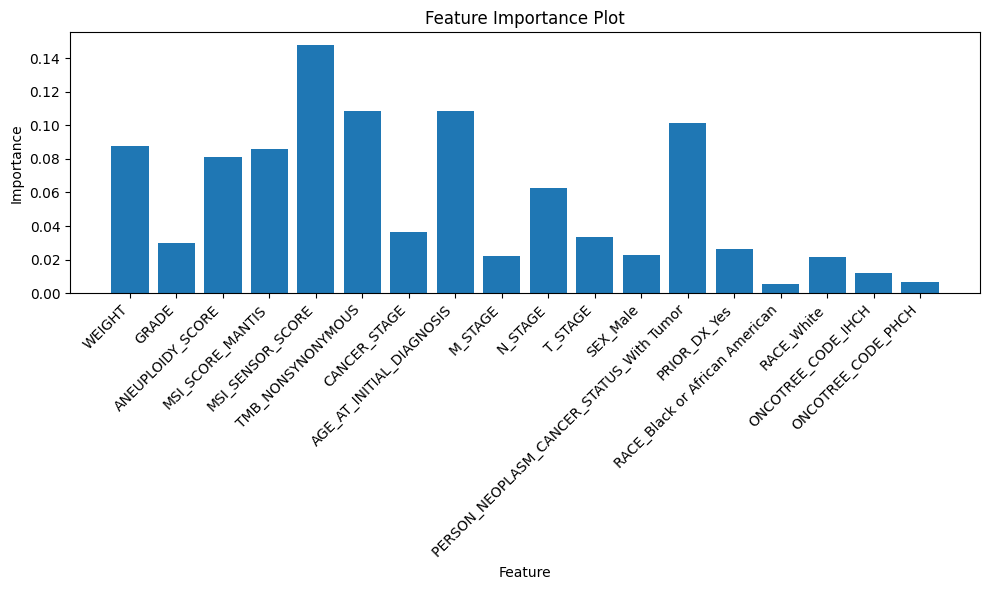

In [17]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming you have your data and labels ready
# X_train, y_train = ...

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=55)

# Train the classifier
rf_classifier.fit(X_std, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get feature names
feature_names = X.columns  # Replace with actual feature names if available

# Create feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Distribution of y bins

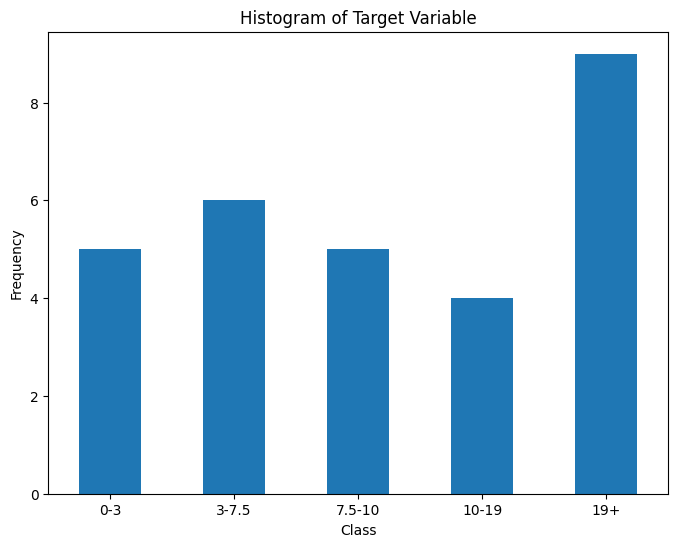

In [21]:
plt.figure(figsize=(8, 6))
custom_order = ['0-3', '3-7.5', '7.5-10', '10-19', '19+']

df["BINNED"].value_counts().reindex(custom_order).plot(kind='bar')
plt.title('Histogram of Target Variable')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()
